In [2]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
import jax
import jax.numpy as jnp
from functions import *
from utils import *

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" 

jax.config.update("jax_enable_x64", True)

def logprior(dmap_flat, num_probes):
    """
    """
    return jnp.sum(jnp.array(logprior_(dmap_flat, num_probes)))

@partial(jax.jit, static_argnums=(1, ))
def logprior_(dmap_flat, num_probes):
    """
    """
    # Get 2D map back to simplify the expression 
    dmap = jnp.reshape(dmap_flat, [num_probes, num_probes])
    
    # Calculate the squared end-to-end distance 
    R_sq = dmap[0][-1] ** 2
    
    # Calculate the average bond length
    b = jnp.mean(jnp.diag(dmap, 1))
    
    N = num_probes
    
    # Calculate the probability
    scaling_factor = 1.5 * jnp.log(3/(2*np.pi*N*b**2))
    gaussian_term = -3*R_sq/(2*N*b**2)
    
    # print('Scaling factor = {}'.format(scaling_factor))
    # print('Gaussian term = {}'.format(gaussian_term))
    
    return scaling_factor, gaussian_term 

def gsm_helper(x, num_components, dimensions):
    # make sure the dimensions are correct
    # assert x.shape[0] == num_components * dimensions
    num_samples = x.shape[0]
    
    # # reshape the input
    # x = jnp.reshape(x, [num_components, dimensions])
    
    vmap_batch_lp = jax.vmap(log_posterior, in_axes=(0, None, None, None, None, None, None))
    
    # calculate the log posterior 
    # change this argument in real function 
    lp = jnp.sum(vmap_batch_lp(x, observation_flatten_list, true_weights, measurement_error, num_probes, num_components, dimensions))
    
    return lp

def log_posterior(metastructures, observations, metastructure_weights,
                  measurement_error, num_probes, num_components, dimensions, num_observations):
    """
    Calculate the logarithm of the posterior probability distribution.

    Parameters
    ----------
    metastructures : 2-dimension array_like
        The metastructures representing the chromatin ensemble.
    observations : array_like
        The flattened observations.
    metastructure_weights : array_like
        The number of observations for each probe.
    measurement_error : float
        The measurement error.
    num_probes : int
        The number of probes.

    Returns
    -------
    float
        The logarithm of the posterior probability distribution.
    """
    metastructures = jnp.array(metastructures)
    # jax.debug.print("{x}", x=metastructures.shape)
    metastructures = jnp.reshape(metastructures, [num_components, dimensions])
    
    # Make sure metastructures, observations, and metastructure_weights are jnp arrays
    
    observations = jnp.array(observations)
    # jax.debug.print("{x}", x=observations.shape)
    metastructure_weights = jax.nn.softmax(metastructure_weights) * num_observations
    metastructure_weights = jnp.reshape(metastructure_weights, [num_components, 1])
    # jax.debug.print("{x}", x=metastructure_weights)
    # jax.debug.print("{x}", x=metastructure_weights)
    # make sure that metastructure_weights is > 0
    # metastructure_weights = jnp.abs(metastructure_weights)
    # metastructure_weights += jnp.finfo(jnp.float64).tiny
    
    # Set weight prior to be categorical distribution
    weight_prior = num_observations/len(metastructure_weights)
    
    # Calculate log posterior in batch using vmap
    vmap_batch_log_posterior = jit(jax.vmap(log_posterior_one_obs, in_axes=(None, 0, None, None, None, None)), static_argnums=(3, 4, 5))
    lp = vmap_batch_log_posterior(metastructures, observations, metastructure_weights, weight_prior, measurement_error, num_probes)
    # jax.debug.print("log prob = {x}, {y}", x=lp, y=metastructure_weights)
    log_posterior_total = jnp.sum(lp)
    
    return log_posterior_total

# Write a helper function to calculate the argument for logsumexp function for each metastructure
def _log_posterior_one_obs_helper(metastructure, observation, metastructure_weight, weight_prior,
                  measurement_error, num_probes):
    """_summary_

    Args:
        metastructures (_type_): _description_
        observations (_type_): _description_
        metastructure_weights (_type_): _description_
        measurement_error (_type_): _description_
        num_probes (_type_): _description_
        batch_size (_type_): _description_
    """
    # Calculate log weights 
    lw = jnp.log(metastructure_weight)
    
    # Calculate log likelihood
    lp = loglikelihood(observation, metastructure, measurement_error, num_probes)
    
    # Calculate log prior weights
    lpw = jnp.log(weight_prior)
    
    # Calculate log prior for metastructure
    lpm = logprior(metastructure, num_probes)
    
    # jax.debug.print("log prob = {x},\n log prior weight = {y},\n log prior metastructure = {z},\n log weights = {a}", x=lp, y=lpw, z=lpm, a=lw)
    
    return lw + lp + lpw + lpm

# Calculate the log posterior inside the logsumexp function
# Use vmap for autobatching 

def log_posterior_one_obs(metastructures, observation, metastructure_weights, weight_prior,
                  measurement_error, num_probes):
    """
    Calculate the logarithm of the posterior probability distribution.

    Parameters
    ----------
    metastructures : 2-dimension array_like
        The metastructures representing the chromatin ensemble.
    observations : array_like
        The flattened observations.
    metastructure_weights : array_like
        The number of observations for each probe.
    measurement_error : float
        The measurement error.
    num_probes : int
        The number of probes.

    Returns
    -------
    float
        The logarithm of the posterior probability distribution.
    """
    # Calculate the argument for logsumexp function 
    vmap_batch_lse_arg = jit(vmap(_log_posterior_one_obs_helper, (0, None, 0, None, None, None)), static_argnums=(3,4,5))
    lse_arg = vmap_batch_lse_arg(metastructures, observation, metastructure_weights, weight_prior, measurement_error, num_probes)
    
    # Calculate LSE
    lse = jax.scipy.special.logsumexp(lse_arg)
    
    return lse

def load_dataset(pickle_file):
    """
    Load the dataset from the pickle file.

    Parameters
    ----------
    pickle_file : str
        The path to the pickle file containing the dataset.

    Returns
    -------
    tuple
        A tuple of the observation list, the true labels, and a dictionary of parameters.

    Raises
    ------
    FileNotFoundError
        If the pickle file does not exist.

    Notes
    -----
    This function loads the dataset from a pickle file. The pickle file should contain a tuple
    with the observation list and the true labels. It also extracts parameters from the file name
    and puts them in a dictionary.

    Example
    -------
    >>> pickle_file = 'data.pickle'
    >>> observation_list, labels_true, param_dict = load_dataset(pickle_file)
    """
    with open(pickle_file, 'rb') as f:
        dataset_list = pickle.load(f)

        
    # Extract parameters from file name
    # Remove .pkl file suffix
    pickle_file = pickle_file.replace('.pkl', '')
    params = os.path.basename(pickle_file).split('_')[1:]
    params = [int(p) if p.isdigit() else float(p) for p in params]

    # Put the parameters in a dictionary
    param_dict = {
        'num_monomers': params[0],
        'mean_bond_length': params[1],
        'std_bond_length': params[2],
        'num_templates': params[3],
        'weights_dist': params[4],
        'noise_std': params[5],
        'num_observations': params[6]
    }
        
    return dataset_list, param_dict


def generate_gaussian_chain_jax(num_monomers: int, 
                            mean_bond_length: float, 
                            std_bond_length: float,
                            key) -> np.ndarray:
    """Generate a Gaussian chain polymer 
    
    Parameters
    ----------
    num_monomers : int 
                  number of polymers in a chain 
    mean_bond_length : float
                      average distance between two neighboring monomers 
    std_bond_length : float
                     standard deviation of distance between two neighboring monomers 
    
    Returns
    ------
    ArrayLike
        an `num_monomers-by-3` numpy.ndarray of monomer coordinates
        
    """ 
    # Generate steps: each step is a 3D vector 
    steps = mean_bond_length + std_bond_length * jax.random.normal(key, shape=(num_monomers, 3))

    # Compute positions by cumulative sum of steps
    positions = jnp.cumsum(steps, axis=0)
    
    return positions

def pdist_jax(X):
    """Compute the pairwise Euclidean distance matrix."""
    X = jnp.asarray(X)
    n = X.shape[0]
    dist_matrix = jax.vmap(
        lambda x: jnp.sqrt(((X - x) ** 2).sum(axis=1))
    )(X)
    return dist_matrix


def squareform_jax(dists):
    """Convert a vector-form distance vector to a square-form distance matrix."""
    n = int(jnp.sqrt(dists.shape[0] * 2) + 1)
    idx = jnp.tril_indices(n, -1)
    result = jnp.zeros((n, n))
    result = result.at[idx].set(dists)
    result = result + result.T
    return result


def compute_squareform_pdist(X):
    """Compute the pairwise distance matrix and convert it to square form."""
    dists = pdist_jax(X)
    dists_tril = dists[jnp.tril_indices(dists.shape[0], k=-1)]
    square_dists = squareform_jax(dists_tril)
    return square_dists

In [3]:
# Load dataset 
p = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_2_1000_20.0_10000.pkl'
dataset_list, param_dict = load_dataset(p)

In [5]:
dataset_idx = 0

In [6]:
# Unpack the param dict
num_monomers = param_dict['num_monomers']
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
weight_dist = param_dict['weights_dist']
num_observations = param_dict['num_observations']
num_probes = num_monomers
num_candidates = num_templates

# Generate variables for the optimization
template_list = dataset_list[dataset_idx]['template_chain_list']
X = dataset_list[dataset_idx]['observation_list']
label_list = dataset_list[dataset_idx]['labels']
observation_flatten_list = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
true_weights = true_weights.reshape(-1, 1)
templates_flatten = [squareform(pdist(x)).flatten() for x in template_list]

# Transform the true weights so that they are not in the simplex
# The input to the optimization algorithm should be in the real space
true_weights_transformed = jnp.log(true_weights) 

lp_structure = jit(lambda x: -log_posterior(x, observation_flatten_list, true_weights_transformed, measurement_error, num_probes, num_candidates, num_monomers**2, num_observations))
lp_weight = jit(lambda x: -log_posterior(templates_flatten, observation_flatten_list, x, measurement_error, num_probes, num_candidates, num_monomers**2, num_observations))

# Generate a starting key
# key = jax.random.PRNGKey(118)
# subkeys = random.split(key, 100)
    
def run_solver_structure():
    # Generate candidate structures
    candidate_polymer_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for _ in range(num_candidates)]
    candidate_flatten_list = [squareform(pdist(polymer)).flatten() for polymer in candidate_polymer_list]

    solver = ProjectedGradient(fun=lp_structure, projection=projection_non_negative, implicit_diff=True, verbose=False)
    sol = solver.run(candidate_flatten_list)
    return jnp.array(sol.params)

def run_solver_weight():
    solver = jaxopt.LBFGS(fun=lp_weight, verbose=False, tol=1e-3, maxls=15, linesearch='backtracking', maxiter=250)
    sol = solver.run(np.random.normal(size=num_candidates))
    pred_weights = jax.nn.softmax(sol.params)
    return pred_weights

pred_weight_list = []
pred_structure_list = []
for iter in tqdm(range(1)):
    pred_weight_list.append(run_solver_weight())
    pred_structure_list.append(run_solver_structure())

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
pred_1, pred_2 = pred_structure_list[0]

In [9]:
temp_1, temp_2 = templates_flatten

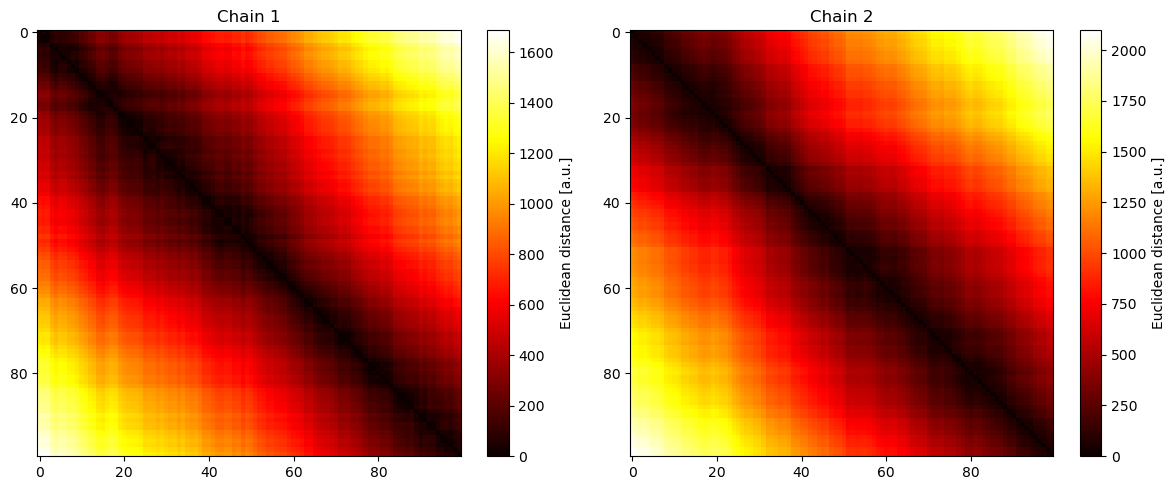

In [11]:
compare_distance_maps(temp_1, pred_1, type1='flatten_distance_map', type2='flatten_distance_map')

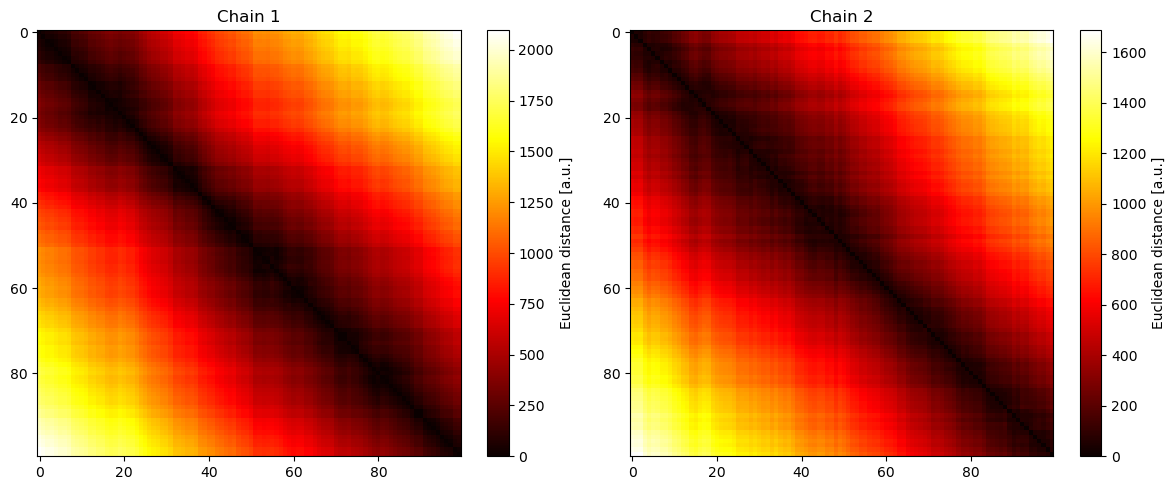

In [12]:
compare_distance_maps(temp_2, pred_2, type1='flatten_distance_map', type2='flatten_distance_map')

In [14]:
true_structure, pred_structure = assign_clusters(np.array(templates_flatten), pred_structure_list[0])

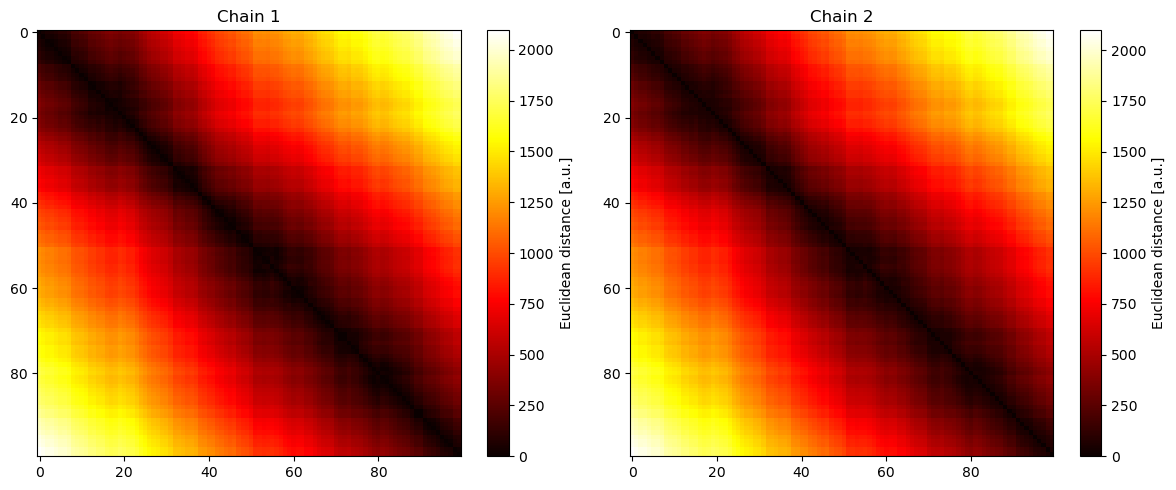

In [15]:
compare_distance_maps(true_structure[0],
                      pred_structure[0], 
                      type1='flatten_distance_map', type2='flatten_distance_map')

In [17]:
np.mean([np.linalg.norm(x-y) for x, y in zip(true_structure, pred_structure)])

530.0542239469933

In [18]:
MSE_means(true_structure, pred_structure)

28.11855401478357